In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, cauchy

# Lecture 5: Monte Carlo, rejection sampling

## Rejection sampling (accept-reject alg.)

In the Bayesian theory, we often meet complicated posterior distributions. In the previous lectures, we elegantly avoided them by using conjugate priors or Laplacian approximations. However, in many cases this is not possible or convenient. Then, the Monte Carlo methods provide a solution of the problem. They consist in simulation of samples from the *posterior distribution* and subsequent calculation of statistics of interest, e.g., the mean value.

The most basic method is the **rejection sampling**, aka **accept-reject algorithm**. It exploits a convenient proposal distribution, from which it is easy to draw samples (= we have a software for it :))

Denote by $f(x)$ the target pdf from which we want to sample. The algorithm is based on the fact, that

$$
f(x) = \int_0^{f(x)} du = \int_0^1 \underbrace{\mathbb{1}_{0<u<f(x)}}_{f(x,u)}du.
$$

Obviously, it is possible to consider $f$ to be a marginal pdf of a joint pdf

$$
(x, u) \sim \mathcal{U}\{(x, u): 0 < u < f(x)\}.
$$

> **Fundamental theorem of simulation**: Simulation of $x\sim f(x)$ is equivalent to sampling $(x, u) \sim \mathcal{U}\{(x, u): 0 < u < f(x)\}$.

This theorem is not useful directly, but it is possible to use a work-around: Simulate $(x, u)$ from a larger set and accept those fulfilling $0 < u < f(x)$.

### Algorithm
Assume $\int_a^b f(x)dx = 1$ and set $m > f(x)$ for all $x\in[a,b]$. We sample $(x', u) \sim \mathcal{U}(0<u<m)$ as follows:
   1. Sample $x' \sim \mathcal{U}(a, b)$,
   2. Sample $u|x=x' \sim \mathcal{U}(0, m)$,
   3. Accept if $0<u<f(x')$.

### Example

In the following example we generate samples from N(0, 1) on [-4, 4].

% acceptance: 0.2513 (754 of 3000)


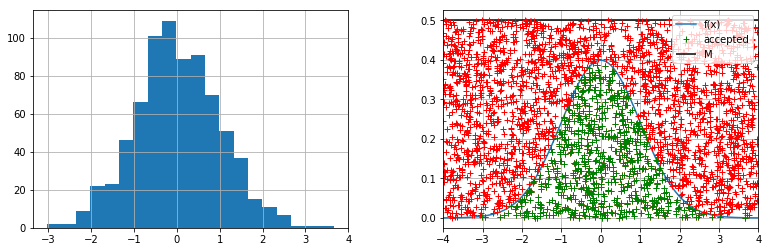

In [3]:
nsamples = 3000     ### Number of samples
M = .5             ### M

samples_u = np.random.uniform(low=0., high=M, size=nsamples)   # uniform samples
samples_x = np.random.uniform(-4, 4, size=nsamples)            # proposal samples
fx = norm.pdf(samples_x)                                       # value of f(x)
accepted = np.where(samples_u < fx)[0]

print("% acceptance: {0:.4f} ({1} of {2})".format(accepted.size/nsamples, accepted.size, nsamples))
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_x[accepted], bins=20)
plt.subplot(122)
x = np.linspace(-4, 4, 100)
plt.plot(x, norm.pdf(x), label='f(x)')
plt.hlines(M, x.min(), x.max(), label='M')
plt.plot(samples_x, samples_u, 'r+')
plt.plot(samples_x[accepted], samples_u[accepted], 'g+', label='accepted')
plt.xlim(-4, 4)
plt.legend()
plt.show()

The given algorithm is useful, but can be significantly improved (why?). It is possible to sample directly over the set

$$
\mathcal{L} = \{(x', u): 0 < u < m(x')\}\qquad\text{where}\qquad m(x) \geq f(x).
$$

Not that the function $m(x)$ is *not* a density (why?). However, we can use a convenient **proposal** $g(x)$, which is a pdf, and a number $M>0$ so that

$$
m(x) = M g(x).
$$

### Algorithm
   1. Sample $x' \sim g$,
   2. Sample $u \sim \mathcal{U}(0, 1)$,
   3. Accept $x'$ if $u\leq \frac{f(x')}{Mg(x')}$.

### Example

Let us again simulate samples from N(0, 1), now using the Cauchy proposal. We shall draw plots for interval [-4, 4], but it is important, that there are samples from the support. If we wanted to restrict sampling to [-4, 4], we would need, e.g., the truncated Cauchy distribution, however, it is not standard.

% acceptance: 0.5700 (171 of 300)


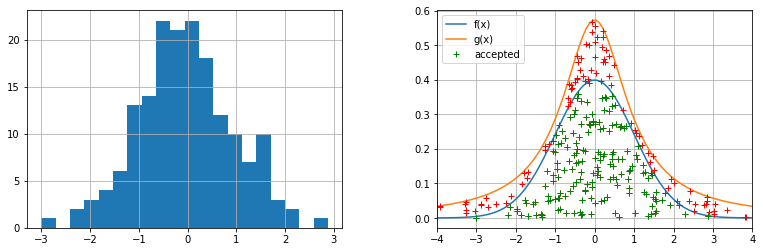

In [4]:
nsamples = 300     ### Number of samples
M = 1.8            ### M

samples_u = np.random.uniform(low=0., high=1., size=nsamples)  # uniform samples
samples_x = cauchy.rvs(size=nsamples)                          # proposal samples
fx = norm.pdf(samples_x)                                       # value of f(x)
ratio = fx / (M * cauchy.pdf(samples_x))
accepted = np.where(samples_u < ratio)[0]

print("% acceptance: {0:.4f} ({1} of {2})".format(accepted.size/nsamples, accepted.size, nsamples))
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_x[accepted], bins=20)
plt.subplot(122)
x = np.linspace(-4, 4, 100)
plt.plot(x, norm.pdf(x), label='f(x)')
plt.plot(x, M*cauchy.pdf(x), '-', label='g(x)')
plt.plot(samples_x, M*cauchy.pdf(samples_x)*samples_u, 'r+')
plt.plot(samples_x[accepted], M*cauchy.pdf(samples_x[accepted])*samples_u[accepted], 'g+', label='accepted')
plt.xlim(-4, 4)
plt.legend()
plt.show()

It is easy to show (and we see it experimentally) that the closer is $M$ to the sampled density, the higher the acceptance. Generally, it is $1/M$.

Rejection sampling is much more effective than the "naive" Monte Carlo. However, it is ineffective in regions where the target density is too concentrated, or where it is too close to zero and most samples are rejected. Let us demonstrate this phenomenon using the first method. The second would be mildly better, but depends on good settings.

% acceptance: 0.0500 (15 of 300)


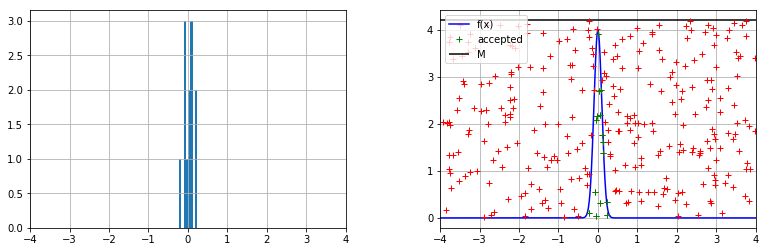

In [8]:
nsamples = 300     ### Number of samples
M = 4.2            ### M

samples_u = np.random.uniform(low=0., high=M, size=nsamples)   # uniform samples
samples_x = np.random.uniform(-4, 4, size=nsamples)            # proposal samples
fx = norm.pdf(samples_x, scale=.1)                             # value of f(x)
accepted = np.where(samples_u < fx)[0]

print("% acceptance: {0:.4f} ({1} of {2})".format(accepted.size/nsamples, accepted.size, nsamples))
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_x[accepted], bins=10)
plt.xlim(-4, 4)
plt.subplot(122)
x = np.linspace(-4, 4, 1000)
plt.plot(x, norm.pdf(x, scale=.1), 'b', label='f(x)')
plt.hlines(M, x.min(), x.max(), label='M')
plt.plot(samples_x, samples_u, 'r+')
plt.plot(samples_x[accepted], samples_u[accepted], 'g+', label='accepted')
plt.xlim(-4, 4)
plt.legend()
plt.show()

---

# Monte Carlo behind the scene - for geeks :)

## Motivation example

Let us first introduce the Monte Carlo principles intuitively. Assume, that we have a circle $\mathcal{K}$ with a radius $r=1$. Its area is

$$
\mathcal{S}_{\mathcal{K}} = \pi r^2 = \pi.
$$

Say, that we want to estimate the parameter $\pi$. For this purpose, we can inscribe the circle into a rectangle $\mathcal{R}$ with a side of length $2r = 2$.

The main principle of Monte Carlo follows from this idea: 

*Suppose, that a uniform rain falls on this figure (circle and rectangle). What is the probability, that a drop falls in the circle?*

The answer is quite straightforward - since the rain is uniform, the probability is a ratio of the circle are to the square area!

$$
P[x_i \in \mathcal{K}] 
= \frac{\mathcal{S}_{\mathcal{K}}}{\mathcal{S}_{\mathcal{R}}}
= \frac{\pi r^2}{2r \cdot 2r}
= \frac{\pi}{4}.
$$

Hence we can simulate from $\mathcal{U}_{[-1,1]\times[-1,1]}$ and test, whether the samples lay in the circle:

In [2]:
def estimate_pi(nsamples):
    samples = np.random.uniform(low=-1, high=1, size=(nsamples, 2))
    samples_dist_from_origin = np.sqrt((samples**2).sum(axis=1))
    samples_in_circle = np.sum(samples_dist_from_origin <= 1)
    probability = samples_in_circle / nsamples
    pi = 4 * probability
    return pi

nsamples = 10000
print('Estimate of pi: {0:.5f}'.format(estimate_pi(nsamples)))

Estimate of pi: 3.13240


## Monte Carlo integration

From mathematical analysis we know, that the integral of a function $f(x)$ over the interval $[a, b]$ is (very vaguely) a sum of rectangles with the height $f(x_i)$ and an infinitesimal side $\Delta x$ (we assume them identical for all $x_i$),

$$
\int_{a}^b f(x) dx \xleftarrow[N\to\infty]{\Delta x \to 0} \sum_{i=1}^{N} f(x_i) \Delta x.
$$

The identical size of $\Delta x$ allows us to uniformly divide the interval $[a,b]$ to $N$ subintervals and consider a mean value of the function

$$
\int_{a}^b f(x) dx \xleftarrow[N\to\infty]{\Delta x \to 0}  \sum_{i=1}^{N} f(x_i) \Delta x
= \frac{b-a}{N}\sum_{i=1}^{N} f(x_i) = V \frac{\sum_{i=1}^{N} f(x_i)}{N} = (b-a) \langle f \rangle,
$$

where we used

$$
\langle f \rangle = \frac{\sum_{i=1}^{N} f(x_i)}{N}
$$

and a volume of the set $V = b - a$.

### Multidimensional case

Generally, the $M$-dimensional case is identical to the unidimensional. We assume functions of $x = [x_1, \ldots, x_M]$ and points $x_i = [x_{i,1}, \ldots, x_{i,M}]$,

$$
\int_{a_1}^{b_1} \cdots \int_{a_M}^{b_M} f(x) dx 
\xleftarrow[N\to\infty]{}
\frac{(b_1 - a_1) \cdots (b_M - a_M)}{N_1 \cdots N_M} \sum_{i_1 = 1}^{N_1} \cdots \sum_{i_M=1}^{N_M} f(x_i)
= V \langle f \rangle,
$$

where $V = (b_1 - a_1) \cdots (b_M - a_M)$ is again the volume of the set, and $\langle f \rangle = \frac{\sum_{i_1 = 1}^{N_1} \cdots \sum_{i_M=1}^{N_M} f(x_i)}{N_1 \cdots N_M}$ is the mean value of $f$.

## Monte Carlo integration

Basic Monte Carlo integration exploits the described principle with the exception that the points $x_i$ are not deterministically selected from a uniformly divided mesh, but are **sampled randomly from a uniform distribution**. Calculation of the mean holds, as well as the determination of the volume. The law of large numbers guarantees, that for the samples $x_i$ where $i=1,\ldots,N$ the Monte Carlo estimate of an integral converges to its true value if $N\to \infty$. In particular, the variance of the mean value of the function is

$$
\mathrm{Var}(f) = \sigma_N^2 = \frac{1}{N}\sum_{i=1}^N (f(x_i) - \langle f \rangle)^2,
$$

and hence the variance of the integral estimate

$$
\mathrm{Var}(V \langle f \rangle) = \frac{V^2}{N^2}\sum_{i=1}^N \operatorname{Var}(f) = V^2 \frac{\sigma_N^2}{N}.
$$

That is, if $N\to\infty$, it holds $\mathrm{Var}(V \langle f \rangle)$ and the error tends to zero.

## Estimation of $\pi$ via Monte Carlo integration

The are of unit circle is $S = \pi r^2 = \pi$. Since we need to integrate a *function*, we need to assume only part of the circle, hence - for instance - the first quadrant. That is,  $S_{\frac{1}{4}} = \frac{\pi}{4}$. The points on the circle boundary satisfy $x^2 + y^2 = r^2 = 1$, i.e., $y = \sqrt{r^2 - x^2} = \sqrt{1 - x^2}$. The area under this function is again 1/4 of the circle area. Hence,

$$
S_{\frac{1}{4}} = \frac{\pi}{4} = \int_{0}^{1} \sqrt{1-x^2}dx \qquad\text{from which we see}\qquad
\pi = 4 \int_{0}^{1} \sqrt{1-x^2}dx.
$$

The resulting algorithm:
   1. Simulate N random samples $x_i \sim \mathcal{U}(0, 1)$.
   2. Calculate mean value of the function over all $x_i$, i.e., $\langle f \rangle = \frac{1}{N} \sum_{i=1}^{N} \sqrt{1-x_i^2}$.
   3. The volume $V = 1 \cdot 1 = 1$.
   4. $\pi = 4 \cdot V \langle f \rangle$.

In [3]:
np.set_printoptions(precision=4)
@np.vectorize
def pi_mc_integration(nsamples):
    xi = np.random.uniform(0, 1, size=nsamples)
    fxi = np.sqrt(1 - xi**2)
    mean = np.mean(fxi)
    return 4 * mean

nsamples = np.power(10, range(8))
pi_estimates = pi_mc_integration(nsamples)
print(np.c_[nsamples, pi_estimates])

[[  1.0000e+00   6.7177e-01]
 [  1.0000e+01   3.1177e+00]
 [  1.0000e+02   3.2108e+00]
 [  1.0000e+03   3.1249e+00]
 [  1.0000e+04   3.1504e+00]
 [  1.0000e+05   3.1430e+00]
 [  1.0000e+06   3.1437e+00]
 [  1.0000e+07   3.1414e+00]]
